In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
# Configuration
# Produce a submission file (you can set this to false if you only
# want to see the cross-validation results)
COMPUTE_TEST_PRED = True

# Containers for results
oof, test_pred = {}, {}

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost
import os
import datetime
import pickle
import warnings
import statsmodels.api as sm

from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, OneHotEncoder
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

initial_features = list(test.columns)
train

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,...,7,8,7,2,2,1,4,6,4,0.495
1117953,2,2,4,3,9,5,8,1,3,5,...,9,4,4,3,7,4,9,4,5,0.480
1117954,7,3,9,4,6,5,9,1,3,4,...,5,5,5,5,6,5,5,2,4,0.485


## Target Distribution

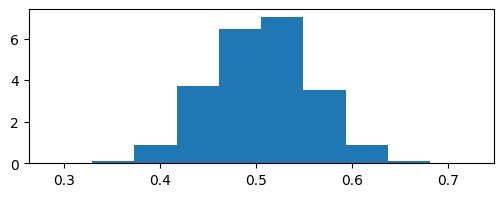

In [5]:
plt.figure(figsize=(6, 2))
plt.hist(train.FloodProbability, density=True)
plt.show()

## Feature Distribution

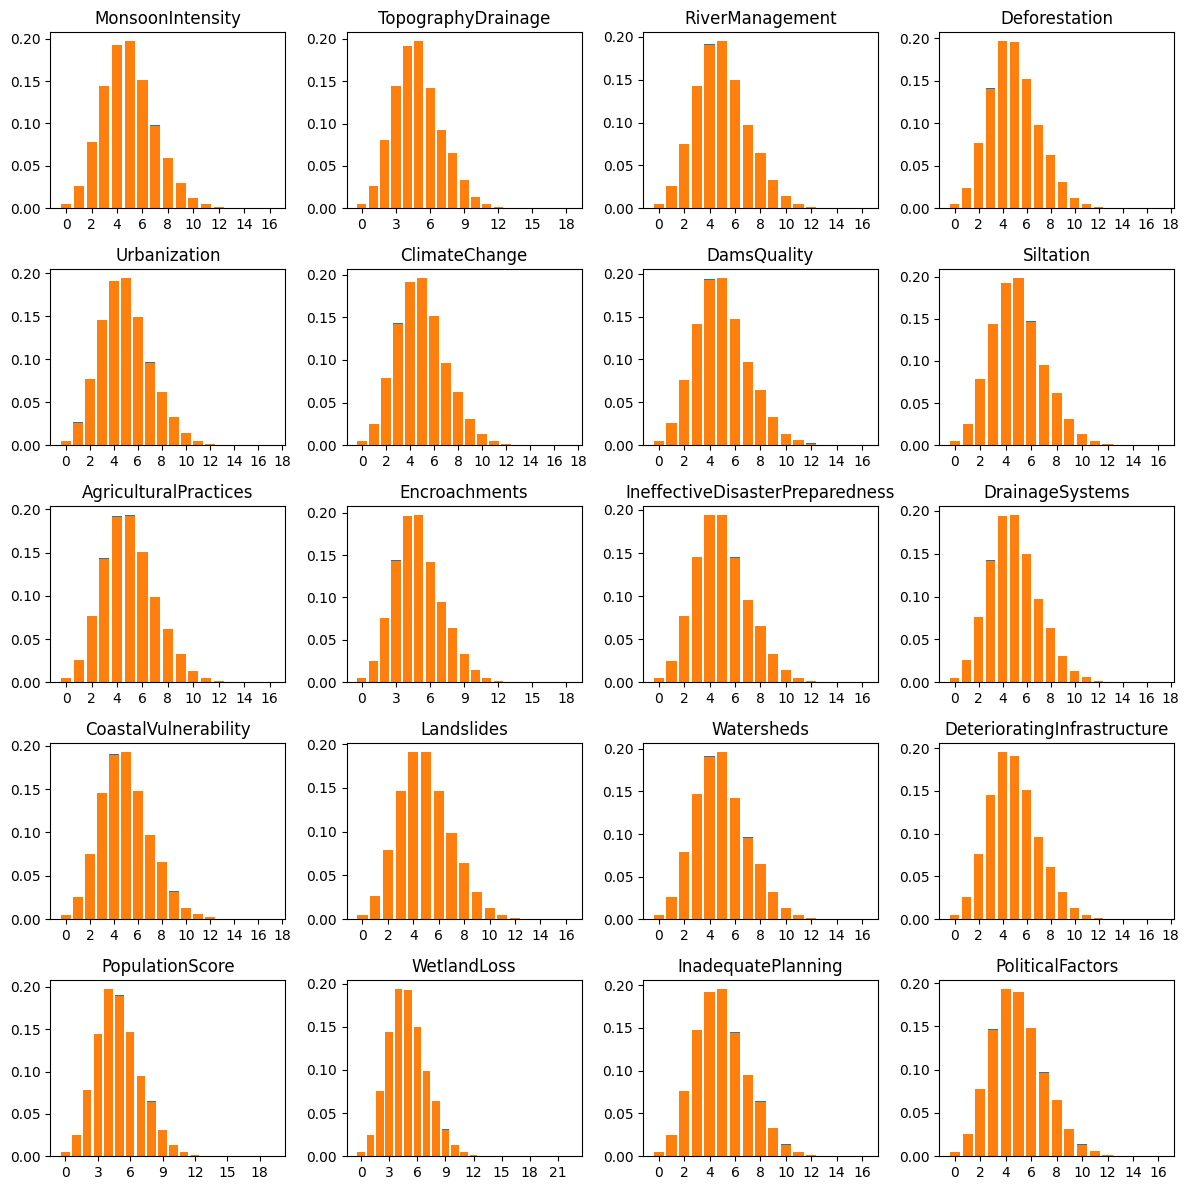

In [6]:
_, axs = plt.subplots(5, 4, figsize=(12, 12))
for col, ax in zip(initial_features, axs.ravel()):
    
    #relative frequency of unique values for each feature
    vc=train[col].value_counts()/len(train)
    ax.bar(vc.index, vc)
    vc=test[col].value_counts()/len(test)
    ax.bar(vc.index, vc)
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # only integer labels
plt.tight_layout()
plt.show()

## Correlations

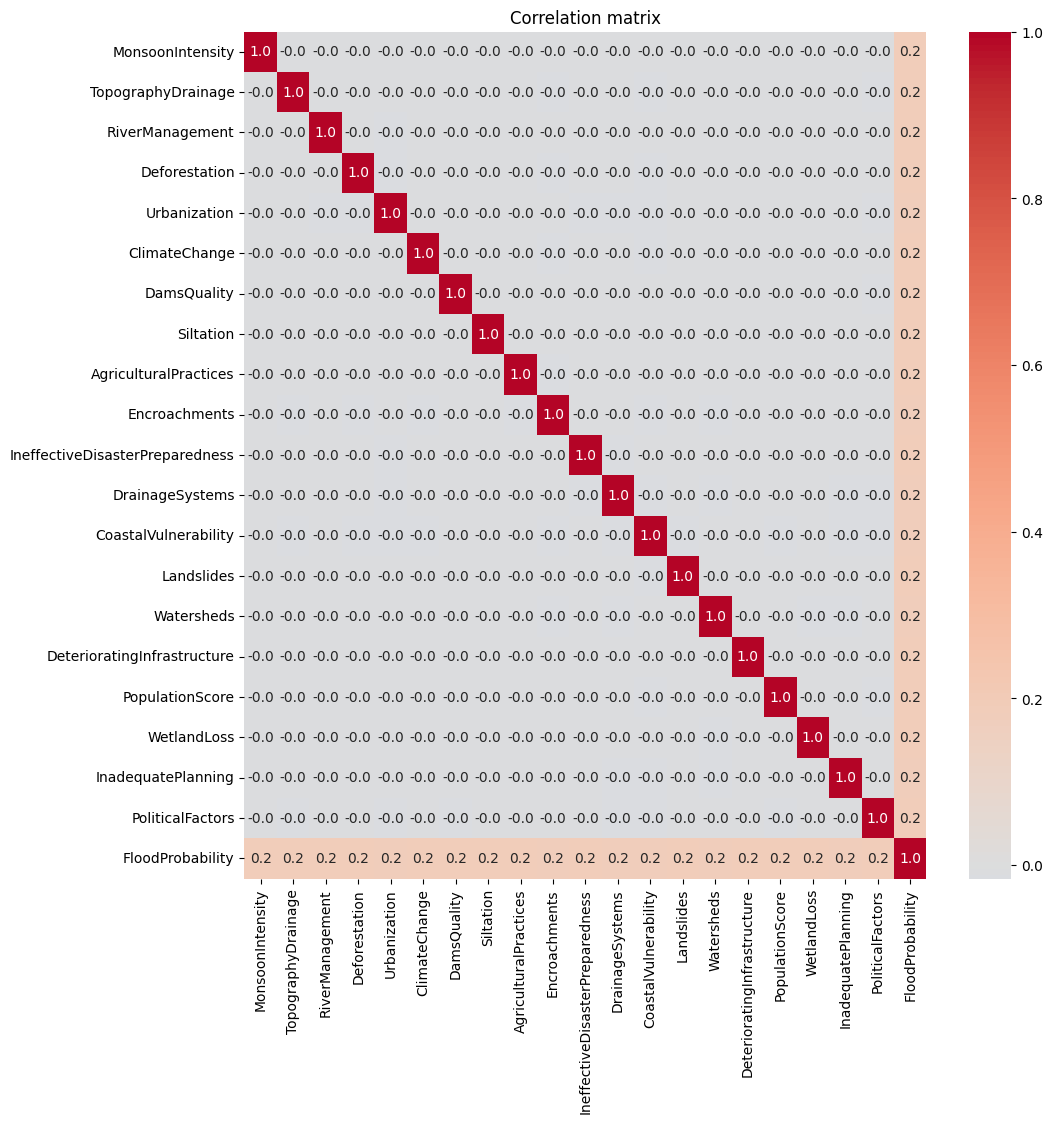

In [7]:
corr_features = initial_features + ['FloodProbability']
cc = np.corrcoef(train[corr_features], rowvar=False)
plt.figure(figsize=(11, 11))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

# Cross validation and training method


### We will use K fold cross validation. Model is trained K times using a different combination of K-1 folds as the training set and remaining as a validation set.

1. `kf.split(train)` will generate indices `idx_tr` and `idx_va` for training and validation.
2. we can select rows of those indices using `.iloc` and the feature columns using `[features]` right after it
3. To store predictions for each fold to validate, we initialize `y_pred` array and fill it with 0's using `np.zeros_like` and pass in `y_va` to make it a similar shape as `y_va`
4. Finally, we fit the model and make predictions to check performance

In [8]:
#splitting data in to 5 folds
kf =KFold(n_splits=5, shuffle=True, random_state=1)

SINGLE_FOLD=True

def cross_validate(model, label, features=initial_features, n_repeats=1):
    start_time = datetime.datetime.now()
    #hold r^2 scores for each fold
    scores=[]
    #array initialized using full_like with NaN values.
    #used to store out of fold predictions
    oof_preds =np.full_like(train.FloodProbability, np.nan, dtype=float)
    
    
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        #training and validation feature sets for a fold
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        
        #target values for training and validation sets for a fold
        y_tr = train.iloc[idx_tr].FloodProbability
        y_va = train.iloc[idx_va].FloodProbability
        
        #initialize array with 0's to store predictions
        y_pred = np.zeros_like(y_va, dtype=float)
        
        for i in range(n_repeats):
            #to avoid modifying original model
            m=clone(model)
            #check to see if model is trained multiple times
            if n_repeats >1:
                #make a local reference to not modify m directly
                mm=m
                #check to see if mm is a pipeline object
                if isinstance(mm, Pipeline):
                    mm=mm[-1]
                mm.set_params(random_state=i)
                #fitting model
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        #after loop of n_repeats of training model, y pred contains the sum of predictions
        #we want to average them out with the number of times we trained the model
        y_pred /= n_repeats
        
        
        #calculate score check predicted (y_pred) with true scores (y_val)
        score = r2_score(y_va, y_pred)
        print(f"# Fold {fold}: R2={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
        if SINGLE_FOLD: break
        
        
    elapsed_time = datetime.datetime.now()-start_time
    print(f"{Fore.GREEN}# OVerall: {np.array(scores).mean():.5f} {label} "
          f"{'single fold' if SINGLE_FOLD else ''}"
          f"{int(np.round(elapsed_time.total_seconds() / 60))}min{Style.RESET_ALL}")
    
    #computing predictions trained on entire train dataframe
    #predictions are made on test set
    if COMPUTE_TEST_PRED:
        y_pred = np.zeros(len(test), dtype=float)
        X_tr = train[features]
        y_tr = train.FloodProbability
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats>1:
                mm= m
                if isinstance(mm, Pipeline):
                    mm=mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        #add the predictions to the global test_pred dict
        test_pred[label] = y_pred
    


# Linear models

#### Made using a Pipeline:
* A workflow that allows you to chain together different steps in data preprocessing and modelings
* `make_pipeline(*steps, memory=none, verbose = False)`
* we will use `StandardScalar()` for the first step of the sequence of transformers 
* we will also use `Ridge()`: linear regression with L2 regularization. A version of regression that prevents overfitting by adding a penalty for large coefficients.

#### We will try 3 different linear models
1. `LinearRegression()`
2. `PolynomialFeatures(degree=2)` with `Ridge()`
3. `SplineTransformer()` with `Ridge()`


In [9]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression')

model = make_pipeline(StandardScaler(),
                      PolynomialFeatures(degree=2),
                      Ridge())
cross_validate(model, 'Poly-Ridge')

model = make_pipeline(StandardScaler(),
                      SplineTransformer(),
                      Ridge())
cross_validate(model, 'Spline-Ridge')

# Fold 0: R2=0.84589
# OVerall: 0.84589 LinearRegression single fold0min
# Fold 0: R2=0.84642
# OVerall: 0.84642 Poly-Ridge single fold0min
# Fold 0: R2=0.84627
# OVerall: 0.84627 Spline-Ridge single fold0min


In [10]:
import statsmodels.api as sm
X = sm.add_constant(train[initial_features])
res = sm.OLS(train.FloodProbability, X, missing='error').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       FloodProbability   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.046e+05
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        06:45:28   Log-Likelihood:             2.7820e+06
No. Observations:             1117957   AIC:                        -5.564e+06
Df Residuals:                 1117936   BIC:                        -5.564e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0533      0.000   -234.995      0.000      -0.054      -0.053
MonsoonIntensity                    0.0056   9.25e-06    606.734      0.000       0.006       0.006
TopographyDrainage                  0.0056   9.09e-06    621.525      0.000       0.006       0.006
RiverManagement                     0.0057   9.18e-06    617.178      0.000       0.006       0.006
Deforestation                       0.0057   9.27e-06    612.404      0.000       0.006       0.006
Urbanization                        0.0057   9.14e-06    619.319      0.000       0.006       0.006
ClimateChange                       0.0057   9.25e-06    612.437      0.000       0.006       0.006
DamsQuality                         0.0057   9.13e-06    619.170      0.000       0.006       0.006
Siltation                           0.0056   9.21e-06    612.284      0.000       0.006       0.006
AgriculturalPractices               0.0056    9.2e-06    612.643      0.000       0.006       0.006
Encroachments                       0.0056   9.14e-06    618.374      0.000       0.006       0.006
IneffectiveDisasterPreparedness     0.0056   9.16e-06    615.995      0.000       0.006       0.006
DrainageSystems                     0.0056   9.18e-06    613.641      0.000       0.006       0.006
CoastalVulnerability                0.0057   9.11e-06    622.228      0.000       0.006       0.006
Landslides                          0.0056   9.15e-06    616.245      0.000       0.006       0.006
Watersheds                          0.0056   9.14e-06    617.853      0.000       0.006       0.006
DeterioratingInfrastructure         0.0056   9.21e-06    609.647      0.000       0.006       0.006
PopulationScore                     0.0057   9.17e-06    618.914      0.000       0.006       0.006
WetlandLoss                         0.0056    9.2e-06    612.654      0.000       0.006       0.006
InadequatePlanning                  0.0056   9.14e-06    613.363      0.000       0.006       0.006
PoliticalFactors                    0.0056    9.1e-06    620.512      0.000       0.006       0.006
==============================================================================
Omnibus:                   100155.250   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148528.907
Skew:                           0.703   Prob(JB):                         0.00
Kurtosis:                       4.100   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# XGBoost

In [11]:
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 100, 'learning_rate': 0.2639887908316703, 'max_depth': 10, 'reg_lambda': 62.46661785864016, 'min_child_weight': 0.33652299514909034, 'colsample_bytree': 0.2319730052165745, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'max_bin': 2048, 'gamma': 0} # 0.83868
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost')

# Fold 0: R2=0.83949
# OVerall: 0.83949 XGBoost single fold0min


# Catboost(no finetuning)

In [12]:
model = catboost.CatBoostRegressor(verbose = False)
cross_validate(model, 'CatBoost')

# Fold 0: R2=0.84722
# OVerall: 0.84722 CatBoost single fold2min


# Feature engineering and advanced models

* The first feature we can analyze is the sum of all features in a single row.

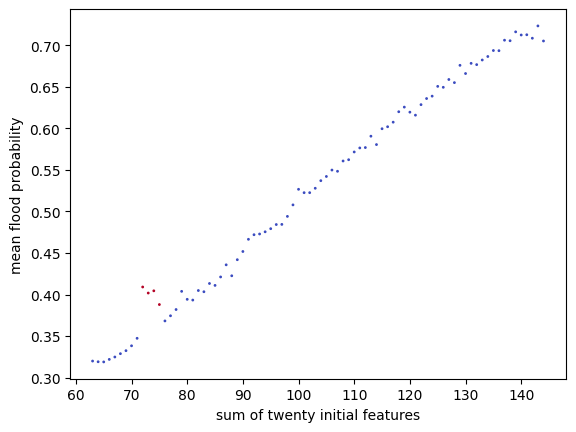

In [13]:
#axis=1 means summation is done along the columns, for each row
row_sum = train[initial_features].sum(axis=1)

temp = train.FloodProbability.groupby(row_sum).mean()
plt.scatter(temp.index, temp, s=1, c=(temp.index.isin(np.arange(72, 76))), cmap='coolwarm')
plt.xlabel('sum of twenty initial features')
plt.ylabel('mean flood probability')
plt.show()

#### Note that when the sum is around 72-76, we see higher probabilities of flood.

In [14]:
for df in [train, test]:
    #using fsum for tree based models since they can learn non-linear trends
    df['fsum'] = df[initial_features].sum(axis=1)
    
    #we store a boolen value in a different column to see if fsum falls in range from
    #72 to 76
    #this is better for linear models after we preprocess this feature
    df['special1'] = df['fsum'].isin(np.arange(72, 76))
    
    

In [15]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression special1', features=initial_features+['special1'])

# Fold 0: R2=0.85218
# OVerall: 0.85218 LinearRegression special1 single fold0min


In [16]:
model = make_pipeline(OneHotEncoder(categories=[np.unique(train.fsum)],
                                    drop='first', sparse_output=False),
                      StandardScaler(),
                      Ridge())
cross_validate(model, 'Ridge one-hot fsum', features=['fsum'])

# Fold 0: R2=0.86660
# OVerall: 0.86660 Ridge one-hot fsum single fold0min


In [18]:
sorted_features = [f"sort_{i}" for i in np.arange(len(initial_features))]
for df in [train, test]:
    df[sorted_features] = np.sort(df[initial_features], axis=1)
train

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,sort_10,sort_11,sort_12,sort_13,sort_14,sort_15,sort_16,sort_17,sort_18,sort_19
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,5,5,5,5,6,7,7,8,8
1,6,7,4,4,8,8,3,5,4,6,...,4,5,5,6,6,7,7,8,8,9
2,6,5,6,7,3,7,1,5,4,5,...,5,6,6,6,6,7,7,7,7,8
3,3,4,6,5,4,8,4,7,6,8,...,5,5,6,6,6,7,7,7,8,8
4,5,3,2,6,4,4,3,3,3,3,...,3,4,4,4,5,5,5,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,...,4,5,5,6,7,7,7,8,10,10
1117953,2,2,4,3,9,5,8,1,3,5,...,4,5,5,5,5,7,8,9,9,9
1117954,7,3,9,4,6,5,9,1,3,4,...,5,5,5,5,5,6,6,7,9,9


In [19]:
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost sorted', features=sorted_features+['fsum'])

# Fold 0: R2=0.87005
# OVerall: 0.87005 CatBoost sorted single fold2min
